# 2D Diffusion Model

This models temperature diffusion over a two dimensional area. <br>

### Input Information:
- Area: x_dimension and y_dimension take input in meters to create a grid.
- Grid cell size: takes input in meters.  Grid cells are square. x_dimension and y_dimension must be divisible by variable grid_cell_size
- Initial temperatures: 2d numpy array for starting temperature at each grid cell.  Dimensions of initial temperature array must match the grid dimensions, or an error will be thrown.
- Boundary conditions: 'boundary' is a 2d numpy array who's outer ring will be the boundary layer for the area.  Note: the boundary_condition variable is just for readability, and isn't checked or enforced.
- Heat Capacity: 2d numpy array for heat capacity at each grid cell.
- End Time: in seconds. Multiply by constants 'DAYS', 'MONTHS', OR 'YEARS' to make longer time periods readable. 

In [3]:
# third party imports
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
%matplotlib inline

# Local application imports
from constants import Constants
from grid2d import Grid
import equations

## Model Inputs:

In [4]:
grid_x_dimension: int = 6
grid_y_dimension: int = 4

grid_cell_size: float = 1

diffusion_constant: float = .1

# Format: (low temperature (inclusive), high temperature (exclusive), (shape))
initial_temperatures: np.ndarray = np.random.randint(225, 326, (grid_y_dimension, grid_x_dimension))


boundary_condition: str = 'dirichlet'
boundary: np.ndarray = np.full((grid_y_dimension+2, grid_x_dimension+2), 280)  # Constant boundary temperature of 280K

heat_capacity: np.ndarray = np.full((grid_y_dimension, grid_x_dimension), 22)

#change the model timing
end_time: float = 5 * Constants.YEARS
time_step: float = 1 * Constants.DAYS
model_times: np.ndarray = np.arange(0, end_time, time_step)
num_steps: int = 5

In [5]:
def area_runge_kutta_calculator(grid: Grid, function: equations.DyDtEquation, time_step: float, num_steps: int) -> np.ndarray:
    """Uses the 4th order runge kutta method to solve a differential equation over an area that includes a boundary.
    
        Parameters:
        -----------
        grid: Grid object
        function: 1st order differential equation of type DyDtEquation. returns 2d numpy array of (dT/dt) at each grid cell midpoint
        initial_values: 2d numpy array with size (y_dimension, x_dimension) containing the initial value of what we are calculating at each grid cell
        time_step: float, length of the time step in seconds
        num_steps: int, how many steps to take"""
            
    
    time = 0
    y_values: np.ndarray = np.zeros((grid.y_dimension+2, grid.x_dimension+2, num_steps+1))
    y_values[:, :, 0] = grid.initial_temperatures
    
    
    for step in range(1, num_steps+1):
    
        k1: np.ndarray = time_step * function(time, grid.current_temperatures)
        k2: np.ndarray = time_step * function((time + .5*time_step), (grid.current_temperatures + .5*k1))
        k3: np.ndarray = time_step * function((time + .5*time_step), (grid.current_temperatures + .5*k2))
        k4: np.ndarray = time_step * function((time + time_step), (grid.current_temperatures + k3))
        
        next_y_values = grid.current_temperatures * (1/6) * (k1 + 2*k2 + 2*k3 + k4)
        
        y_values[:, :, step] = next_y_values
        grid.set_temperatures(next_y_values[1:-1, 1:-1])
    
    return y_values
    

In [11]:
#print("Is this working?")
#initialize the grid
grid = Grid(grid_x_dimension, grid_y_dimension)

grid.set_initial_temperatures(initial_temperatures)
grid.set_boundary_condition(boundary_condition)
grid.set_boundary(boundary)
grid.set_heat_capacity(heat_capacity)

# array = np.full((4, 6), 5)
# grid.boundary[1:-1, 1:-1] = array
# print(f"Array: \n {array}")
# print(f"Added Array:\n {grid.boundary}")

# print(f"initial_temperatures:\n {grid.initial_temperatures}")
# print(f"boundary:\n {grid.boundary}")
# print(f"temperatures + boundary:\n {grid.initial_temperatures + grid.boundary}")

x_diffusion = equations.XDirectionDiffusion(diffusion_constant, grid)
y_diffusion = equations.YDirectionDiffusion(diffusion_constant, grid)

x_direction_diffusion: np.ndarray = area_runge_kutta_calculator(grid, x_diffusion, time_step, num_steps)

#x_diffusion = solve_ivp(x_diffusion, (0, end_time), y0=grid.initial_temperatures, method='RK45', t_eval=model_times)
#y_diffusion = solve_ivp()

#print(x_direction_diffusion[:, :, 4])


### Plotting

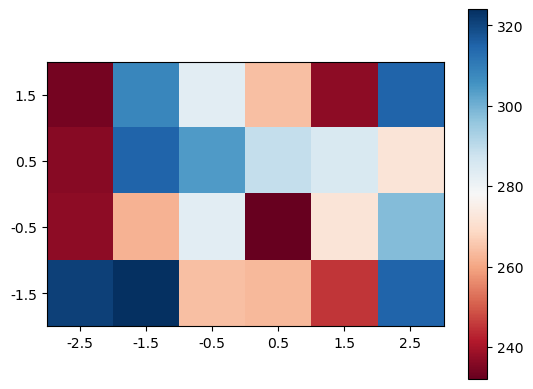

In [25]:
#create the tick marks on the x and y axis
x_axis: np.ndarray = np.linspace((-1 * (grid_x_dimension-1)/2), (grid_x_dimension-1)/2, grid_x_dimension)
y_axis: np.ndarray = np.linspace((grid_y_dimension-1)/2, -1 * (grid_y_dimension-1)/2, grid_y_dimension)

#choose where the ticks go
y_segment_length = grid.y_segment_length
x_axis_tick_locations: np.ndarray = np.arange(0, grid_x_dimension, grid.x_segment_length)
y_axis_tick_locations: np.ndarray = np.arange(0, grid_y_dimension, grid.y_segment_length)

x_coordinates, y_coordinates = np.meshgrid(x_axis, y_axis)

z = grid.temperatures[1:-1, 1:-1]


fig, ax = plt.subplots()

#set tick marks
ax.set_xticks(x_axis_tick_locations)
ax.set_xticklabels(x_axis)
ax.set_yticks(y_axis_tick_locations)
ax.set_yticklabels(y_axis)
temperature_data = ax.imshow(grid.temperatures[1:-1, 1:-1], cmap='RdBu')

#colorbar
colorbar = fig.colorbar(temperature_data)


plt.show()


In [2]:
# One Dimensional Nonequilbrium Energy Balance Model with Diffusion 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from fontTools.ttLib.tables.otTables import DeltaSetIndexMap
from numpy.ma.core import true_divide
from scipy.integrate import solve_ivp

%matplotlib inline

EARTH_RADIUS = 6.371E6 #in meters
EMISSIVITY_FRACTION = 0.82
STEFAN_BOLTZMANN_CONSTANT = 5.67E-8 #in W / m^2 / K^4
SILICON_ROCK_HEAT_CAPACITY = 712  #in J /kg / K
SILICON_ROCK_DENSITY = 2650  #in kg/m^3
WATER_HEAT_CAPACITY = 4000  #in J /kg / K
WATER_DENSITY = 1000  #in kg/m^3

DAYS_PER_YEAR = 365.25
HOURS_PER_DAY = 24
SECONDS_PER_HOUR = 3600
SECONDS_PER_DAY = HOURS_PER_DAY * SECONDS_PER_HOUR
SECONDS_PER_YEAR = DAYS_PER_YEAR * SECONDS_PER_DAY

SOLAR_INSOLATION = 1361  #in W m-2
DEGREES_TO_RADIANS = np.pi / 180.0

# set model parameters
ALBEDO = 0.32
depth = 100  # Depth of ocean mixed layer/land active layer, in m

# create grid and set initial conditions
num_segments = 50
interface_positions = np.linspace(-1, 1, num_segments + 1)
midpoint_positions = (interface_positions[0:num_segments] + interface_positions[1:num_segments + 1]) / 2
segment_length = interface_positions[1] - interface_positions[0]
model_lat = np.arcsin(midpoint_positions) / DEGREES_TO_RADIANS

DIFFUSION_COEFFICIENT = 0.1

# set time integration parameters
t_end = 25 * SECONDS_PER_YEAR  # integration end time
dt = 10 * SECONDS_PER_DAY  # time integration maximum step size
DT_BETWEEN_PLOTS = 60 * SECONDS_PER_DAY  # time between plots
times = np.arange(0, t_end, DT_BETWEEN_PLOTS)  # array of timesteps for output
times_for_finding_equilibrium_temperature = np.arange(0, 20 * t_end, DT_BETWEEN_PLOTS)
print(f"num_steps = {t_end / dt}")


initial_temperatures = 288 + 0 * midpoint_positions  # constant initial temperature


EARTH_VOLUME = 4 * np.pi * EARTH_RADIUS ** 2 * depth  # Volume of top x-meters of earth (given by depth)
EARTH_HEAT_CAPACITY = (0.7 * (WATER_HEAT_CAPACITY * EARTH_VOLUME * WATER_DENSITY) +
                       0.3 * (SILICON_ROCK_HEAT_CAPACITY * EARTH_VOLUME * SILICON_ROCK_DENSITY)) #in J K-1
EARTH_HEAT_CAPACITY_PER_UNIT_AREA = EARTH_HEAT_CAPACITY / (4 * np.pi * EARTH_RADIUS ** 2)  #in J m-2 K-1
print(f"EARTH_HEAT_CAPACITY: {EARTH_HEAT_CAPACITY}")
print(f"EARTH_HEAT_CAPACITY_PER_UNIT_AREA: {EARTH_HEAT_CAPACITY_PER_UNIT_AREA}")

num_steps = 913.125
EARTH_HEAT_CAPACITY: 1.7168974150272234e+23
EARTH_HEAT_CAPACITY_PER_UNIT_AREA: 336603999.99999994
